#**📌 Notebook Overview**


In this notebook, we explore different types of algorithms for the Next POI Recommendation System. We systematically implement, evaluate, and compare various models.




1️⃣ **Graph-Based Recommendation Models**

- Directed Acyclic Graph (DAG)
- Personalized PageRank (PPR)
- Node2Vec

2️⃣ **Deep Learning Models**

- LSTM (Long Short-Term Memory)

- GNN (Graph Neural Networks)


3️⃣ **Collaborative Filtering Models**

- User-Based CF

- Item-Based CF

4️⃣ **Hybrid Models**

- Combining Graph-Based + Deep Learning.



#**Install Dependencies**

In [ ]:
!pip install node2vec gensim

In [ ]:
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from node2vec import Node2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.manifold import TSNE

import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Masking, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split

Load dataset


In [ ]:
file_path = "/content/cleaned_poi_dataset (1).csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

#**1. Graph-Based Recommendation Models**
we will explore
1. DAG (Directed Acyclic Graph)
2. PPR (Personalized PageRank)
3. Node2Vec (Graph Embedding Model)

##**1. DAG**

📌 Function to Build DAG

In [ ]:
def build_dag(df):
    """
    Constructs a Directed Acyclic Graph (DAG) for venue transitions.

    Args:
        df (pd.DataFrame): The POI dataset with columns ['Previous Venue ID', 'Venue ID'].

    Returns:
        G (nx.DiGraph): A directed graph with venue transitions.
    """

    # Create a Directed Graph
    G = nx.DiGraph()

    # Loop through the dataset to add edges (transitions)
    for _, row in df.iterrows():
        prev_venue = row["Previous Venue ID"]
        next_venue = row["Venue ID"]

        # Ensure both values exist
        if pd.notna(prev_venue) and pd.notna(next_venue):
            # If edge exists, increase weight (transition count)
            if G.has_edge(prev_venue, next_venue):
                G[prev_venue][next_venue]['weight'] += 1
            else:
                G.add_edge(prev_venue, next_venue, weight=1)  # Initialize weight

    return G

📌 Running the DAG Construction

In [ ]:
# Build the DAG
G_dag = build_dag(df)

# Print basic DAG info
print(f"✅ DAG constructed with {G_dag.number_of_nodes()} venues and {G_dag.number_of_edges()} transitions.")

✅ DAG constructed with 583 venues and 911 transitions.


📌 Implementing DAG-Based Recommendation

In [ ]:
def recommend_dag(current_venue, G, top_n=5):
    """
    Recommend next venues based on transition history in DAG.

    Args:
        current_venue (str): The Venue ID of the current location.
        G (nx.DiGraph): The DAG containing venue transitions.
        top_n (int): Number of top recommendations to return.

    Returns:
        list: Recommended venue IDs.
    """

    if current_venue in G:
        # Sort venues by transition weight (most frequent transitions first)
        sorted_venues = sorted(G[current_venue], key=lambda v: G[current_venue][v]['weight'], reverse=True)
        return sorted_venues[:top_n]

    return []  # Return empty list if the venue is not found

📌 Running the DAG-Based Recommendation

In [ ]:
# Test the DAG recommendation function
sample_venue = "V231"  # Replace with an actual Venue ID from your dataset
recommendations = recommend_dag(sample_venue, G_dag, top_n=3)

print(f"Top recommended venues after {sample_venue}: {recommendations}")

Top recommended venues after V231: ['V67']


📌 Visualizing the DAG Model

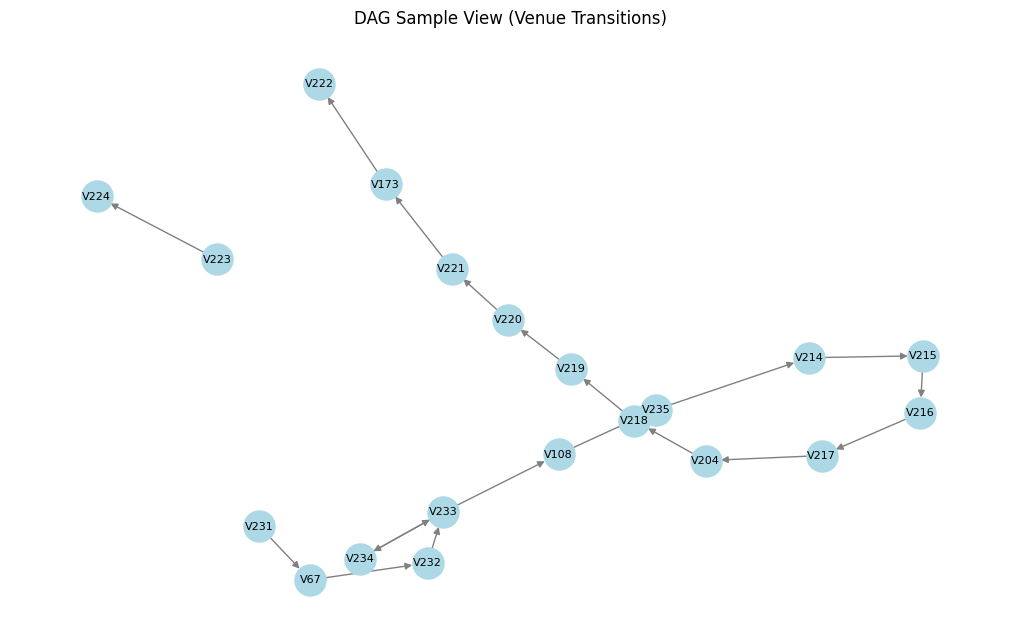

In [ ]:
def plot_dag(G, sample_size=20):
    """
    Plots a sample of the DAG.

    Args:
        G (nx.DiGraph): The DAG model.
        sample_size (int): Number of nodes to visualize.
    """
    plt.figure(figsize=(10, 6))

    # Extract a subgraph (sample_size nodes)
    sampled_nodes = list(G.nodes)[:sample_size]
    subgraph = G.subgraph(sampled_nodes)

    # Draw the graph
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)
    plt.title("DAG Sample View (Venue Transitions)")
    plt.show()

# Plot a sample of the DAG
plot_dag(G_dag, sample_size=20)

📌 Training and Evaluating the DAG Model

In [ ]:
def evaluate_dag_model(df, G, top_n=3):
    """
    Evaluate the DAG model by comparing predicted vs. actual next venues.

    Args:
        df (pd.DataFrame): The POI dataset.
        G (nx.DiGraph): The DAG model.
        top_n (int): Number of top recommendations to consider.

    Returns:
        dict: Accuracy, precision, recall, and F1-score.
    """
    true_labels = []
    predicted_labels = []

    for _, row in df.iterrows():
        prev_venue = row["Previous Venue ID"]
        actual_next_venue = row["Venue ID"]

        # Skip rows without a previous venue
        if pd.isna(prev_venue) or pd.isna(actual_next_venue):
            continue

        # Get DAG predictions
        predicted_venues = recommend_dag(prev_venue, G, top_n)

        # Store actual and predicted values
        true_labels.append(actual_next_venue)
        predicted_labels.append(predicted_venues[0] if predicted_venues else "Unknown")

    # Filter out "Unknown" predictions (venues not in DAG)
    filtered_true = []
    filtered_pred = []

    for true, pred in zip(true_labels, predicted_labels):
        if pred != "Unknown":
            filtered_true.append(true)
            filtered_pred.append(pred)

    # Compute Metrics
    accuracy = accuracy_score(filtered_true, filtered_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(filtered_true, filtered_pred, average='weighted', zero_division=0)


    return {
        "Accuracy": accuracy * 100,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

📌 Running the Evaluation

In [ ]:
# Build DAG model
G_dag = build_dag(df)

# Evaluate the DAG model
dag_metrics = evaluate_dag_model(df, G_dag, top_n=3)

# Print evaluation results
print(f"✅ DAG Model Evaluation-augmentation:")
for metric, value in dag_metrics.items():
    print(f"{metric}: {value:.2f}")

✅ DAG Model Evaluation-augmentation:
Accuracy: 63.16
Precision: 0.60
Recall: 0.63
F1 Score: 0.58


##**2. Personalized PageRank Model**

📌 Step 1: Build the Graph


In [ ]:
# Build a Directed Graph
G = nx.DiGraph()

# Add edges from Previous Venue -> Current Venue
for _, row in df.iterrows():
    prev_venue = row["Previous Venue ID"]
    next_venue = row["Venue ID"]

    if pd.notna(prev_venue) and pd.notna(next_venue):
        if G.has_edge(prev_venue, next_venue):
            G[prev_venue][next_venue]['weight'] += 1
        else:
            G.add_edge(prev_venue, next_venue, weight=1)

print(f"✅ Graph Created with {len(G.nodes())} nodes and {len(G.edges())} edges")

✅ Graph Created with 583 nodes and 911 edges


📌 Step 2: Compute Personalized PageRank (PPR)


In [ ]:
def recommend_ppr(user_history, top_n=5, alpha=0.3):
    """ Recommends venues using Personalized PageRank """
    personalized = {venue: 1.0 for venue in user_history}  # Give weight to visited venues
    ppr_scores = nx.pagerank(G, alpha=alpha, personalization=personalized)

    # Rank venues by PageRank score
    sorted_venues = sorted(ppr_scores.keys(), key=lambda v: ppr_scores[v], reverse=True)

    return sorted_venues[:top_n]

# Example Usage
user_history = ["V101", "V202", "V305"]  # Replace with a real user history
recommendations = recommend_ppr(user_history, top_n=5)
print(f"🎯 Recommended Venues: {recommendations}")

🎯 Recommended Venues: ['V202', 'V101', 'V305', 'V306', 'V563']


📌 Step 3: Evaluate the Model


In [ ]:
correct_predictions = 0
total_predictions = 0

test_data = df.tail(int(0.2 * len(df)))  # Last 20% as test data

for _, row in test_data.iterrows():
    user_history = df[df['User ID'] == row["User ID"]]["Previous Venue ID"].dropna().unique()
    true_next_venue = row["Venue ID"]

    predicted_venues = recommend_ppr(user_history, top_n=5)

    if true_next_venue in predicted_venues:
        correct_predictions += 1

    total_predictions += 1

# Calculate Accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"🔥 Personalized PageRank Model Accuracy-augemntation: {accuracy:.2f}%")

🔥 Personalized PageRank Model Accuracy-augemntation: 35.94%


📌 Step 4: Visualizing the Graph


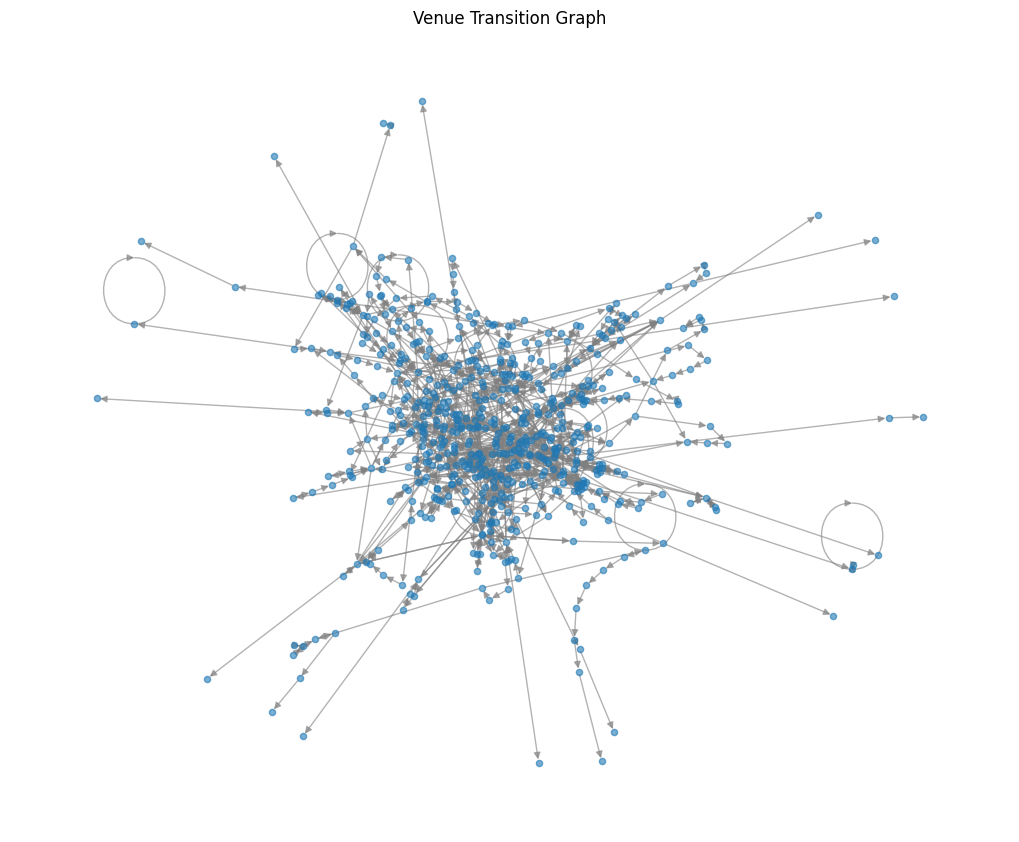

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw(G, node_size=20, alpha=0.6, edge_color="gray", with_labels=False)
plt.title("Venue Transition Graph")
plt.show()

📌 Compute Precision, Recall, and F1-Score

In [ ]:
# Lists to store evaluation results
true_labels = []
predicted_labels = []

# Evaluate on Test Data
test_data = df.tail(int(0.2 * len(df)))  # Last 20% as test data

for _, row in test_data.iterrows():
    user_history = df[df['User ID'] == row["User ID"]]["Previous Venue ID"].dropna().unique()
    true_next_venue = row["Venue ID"]

    predicted_venues = recommend_ppr(user_history, top_n=5)

    true_labels.append(true_next_venue)
    predicted_labels.append(predicted_venues[0] if predicted_venues else "Unknown")  # Take the top prediction

# Remove "Unknown" cases (where PPR failed)
filtered_true_labels = []
filtered_predicted_labels = []

for true, pred in zip(true_labels, predicted_labels):
    if pred != "Unknown":
        filtered_true_labels.append(true)
        filtered_predicted_labels.append(pred)

# Compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(filtered_true_labels, filtered_predicted_labels, average="weighted")

# List to store reciprocal ranks
reciprocal_ranks = []

# Evaluate on Test Data
test_data = df.tail(int(0.2 * len(df)))  # Use last 20% as test data

for _, row in test_data.iterrows():
    user_history = df[df['User ID'] == row["User ID"]]["Previous Venue ID"].dropna().unique()
    true_next_venue = row["Venue ID"]

    # Get ranked list of predictions
    predicted_venues = recommend_ppr(user_history, top_n=5)

    if true_next_venue in predicted_venues:
        rank = predicted_venues.index(true_next_venue) + 1  # Get position (1-based index)
        reciprocal_ranks.append(1 / rank)  # Compute reciprocal rank
    else:
        reciprocal_ranks.append(0)  # No correct prediction
print(f"🔥 Precision: {precision:.2f}")
print(f"🎯 Recall: {recall:.2f}")
print(f"🚀 F1 Score: {f1_score:.2f}")
# Compute MRR
mrr_score = np.mean(reciprocal_ranks)
print(f"🔥 Mean Reciprocal Rank (MRR): {mrr_score:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔥 Precision: 0.05
🎯 Recall: 0.16
🚀 F1 Score: 0.07
🔥 Mean Reciprocal Rank (MRR): 0.2271


##**3. Node2Vec**

📌 Construct the Graph

In [ ]:
# List to store reciprocal ranks
reciprocal_ranks = []

# Evaluate on Test Data
test_data = df.tail(int(0.2 * len(df)))  # Use last 20% as test data

for _, row in test_data.iterrows():
    user_history = df[df['User ID'] == row["User ID"]]["Previous Venue ID"].dropna().unique()
    true_next_venue = row["Venue ID"]

    # Get ranked list of predictions
    predicted_venues = recommend_ppr(user_history, top_n=5)

    if true_next_venue in predicted_venues:
        rank = predicted_venues.index(true_next_venue) + 1  # Get position (1-based index)
        reciprocal_ranks.append(1 / rank)  # Compute reciprocal rank
    else:
        reciprocal_ranks.append(0)  # No correct prediction

📌 Train the Node2Vec Model

In [ ]:
# Generate Node2Vec walks
node2vec = Node2Vec(G,p=1, q=2, dimensions=32, walk_length=10, num_walks=50, workers=4)

# Train Word2Vec model
model = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/583 [00:00<?, ?it/s]

In [ ]:
df = df.dropna(subset=["Previous Venue ID", "Venue ID"])
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)
df["Venue ID"] = df["Venue ID"].astype(str)

📌 Define Recommendation Function

In [ ]:
def recommend_node2vec(venue_id, top_n=5):
    """ Recommends similar venues using Node2Vec embeddings. """
    if venue_id in model.wv:
        similar_venues = model.wv.most_similar(venue_id, topn=top_n)
        return [venue[0] for venue in similar_venues]
    return []

📌 Evaluate the Node2Vec Model

In [ ]:
# Get test data (last 20% of dataset)
test_size = int(0.2 * len(df))
test_data = df.tail(test_size)

correct_predictions = 0
total_predictions = 0

for _, row in test_data.iterrows():
    true_next_venue = row["Venue ID"]
    predicted_venues = recommend_node2vec(row["Previous Venue ID"], top_n=5)

    if true_next_venue in predicted_venues:
        correct_predictions += 1

    total_predictions += 1

# Compute accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"🔥 Node2Vec Model Accuracy: {accuracy:.2f}%")

🔥 Node2Vec Model Accuracy: 61.70%


📌 Compute Precision, Recall, and F1 Score

In [ ]:
y_true = []
y_pred = []

for _, row in test_data.iterrows():
    true_venue = row["Venue ID"]
    predicted_venues = recommend_node2vec(row["Previous Venue ID"], top_n=1)

    y_true.append(true_venue)
    y_pred.append(predicted_venues[0] if predicted_venues else "Unknown")

# Remove "Unknown" cases
filtered_y_true = []
filtered_y_pred = []

for true, pred in zip(y_true, y_pred):
    if pred != "Unknown":
        filtered_y_true.append(true)
        filtered_y_pred.append(pred)

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(filtered_y_true, filtered_y_pred, average="weighted")

print(f"🎯 Precision: {precision:.2f}")
print(f"🔥 Recall: {recall:.2f}")
print(f"🚀 F1 Score: {f1:.2f}")

🎯 Precision: 0.30
🔥 Recall: 0.26
🚀 F1 Score: 0.22


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Visualize Venue Embeddings

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


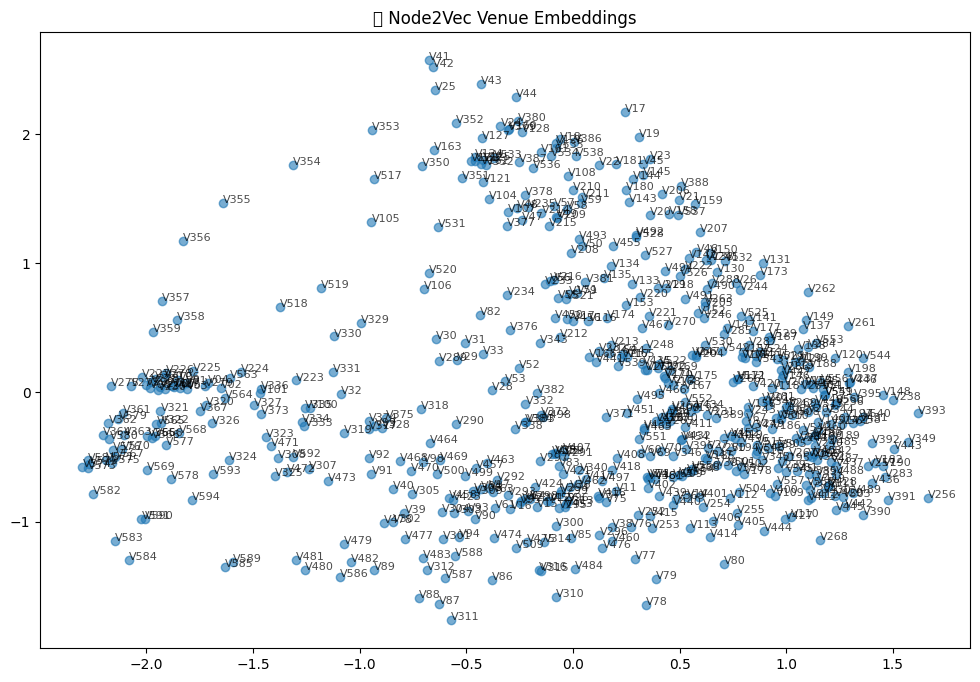

In [ ]:
# Get venue embeddings
venue_ids = list(model.wv.index_to_key)
embeddings = np.array([model.wv[venue] for venue in venue_ids])

# Reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
for i, venue in enumerate(venue_ids):
    plt.annotate(venue, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)
plt.title("📌 Node2Vec Venue Embeddings")
plt.show()

#**2. Deep Learning Models**
we will explore
1. LSTM (Long Short-Term Memory)
2. GNN (Graph Neural Networks)

##**1. LSTM**

In [ ]:
# Load the cleaned dataset (ensure the file is in your working directory)
df = pd.read_csv("/content/cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User ID            964 non-null    int64  
 1   Venue ID           964 non-null    object 
 2   Latitude           964 non-null    float64
 3   Longitude          964 non-null    float64
 4   Check-in Time      964 non-null    object 
 5   Day                964 non-null    object 
 6   Previous Venue ID  942 non-null    object 
 7   Venue Name         964 non-null    object 
 8   Venue Category     964 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 67.9+ KB
None


,User ID,Venue ID,Latitude,Longitude,Check-in Time,Day,Previous Venue ID,Venue Name,Venue Category
0,1,V231,24.767113,46.659294,2021-01-05 22:31:00.000,Tuesday,NaN,margherita,restaurant
1,1,V67,24.772194,46.698083,2021-01-05 23:52:00.000,Tuesday,V231,riverwalk,plaza
2,1,V232,24.790579,46.612207,2021-01-06 23:59:00.000,Wednesday,V67,amc cinemas,entertainment
3,1,V233,24.760748,46.716174,2021-01-09 20:12:00.000,Saturday,V232,third caf,coffee shop
4,1,V234,24.741122,46.636161,2021-01-27 11:39:00.000,Wednesday,V233,caribou coffee,coffee shop


In [ ]:
# Remove 'V' prefix and convert Venue IDs to integers
df["Venue ID"] = df["Venue ID"].astype(str).str.replace("V", "").astype(int)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str).str.replace("V", "")
# (We leave Previous Venue ID as string or process similarly if needed)

# Convert 'Check-in Time' to datetime and sort the data
df["Check-in Time"] = pd.to_datetime(df["Check-in Time"], errors='coerce')
df = df.sort_values(by=["User ID", "Check-in Time"])
df.head()

,User ID,Venue ID,Latitude,Longitude,Check-in Time,Day,Previous Venue ID,Venue Name,Venue Category
0,1,231,24.767113,46.659294,2021-01-05 22:31:00,Tuesday,nan,margherita,restaurant
1,1,67,24.772194,46.698083,2021-01-05 23:52:00,Tuesday,231,riverwalk,plaza
2,1,232,24.790579,46.612207,2021-01-06 23:59:00,Wednesday,67,amc cinemas,entertainment
3,1,233,24.760748,46.716174,2021-01-09 20:12:00,Saturday,232,third caf,coffee shop
4,1,234,24.741122,46.636161,2021-01-27 11:39:00,Wednesday,233,caribou coffee,coffee shop


In [ ]:
# Assuming df is your DataFrame after cleaning and before creating sequences

# Normalize Latitude to [0, 1]
lat_min = df["Latitude"].min()
lat_max = df["Latitude"].max()
df["Latitude_norm"] = (df["Latitude"] - lat_min) / (lat_max - lat_min)

# Normalize Longitude to [0, 1]
lon_min = df["Longitude"].min()
lon_max = df["Longitude"].max()
df["Longitude_norm"] = (df["Longitude"] - lon_min) / (lon_max - lon_min)

# Optionally, inspect the normalized columns
print("Latitude normalized range:", df["Latitude_norm"].min(), "-", df["Latitude_norm"].max())
print("Longitude normalized range:", df["Longitude_norm"].min(), "-", df["Longitude_norm"].max())

# Use these normalized coordinates as the target for the model
df.head()

Latitude normalized range: 0.0 - 1.0
Longitude normalized range: 0.0 - 1.0


,User ID,Venue ID,Latitude,Longitude,Check-in Time,Day,Previous Venue ID,Venue Name,Venue Category,Latitude_norm,Longitude_norm
0,1,231,24.767113,46.659294,2021-01-05 22:31:00,Tuesday,nan,margherita,restaurant,0.647253,0.407321
1,1,67,24.772194,46.698083,2021-01-05 23:52:00,Tuesday,231,riverwalk,plaza,0.656486,0.524823
2,1,232,24.790579,46.612207,2021-01-06 23:59:00,Wednesday,67,amc cinemas,entertainment,0.689897,0.264681
3,1,233,24.760748,46.716174,2021-01-09 20:12:00,Saturday,232,third caf,coffee shop,0.635686,0.579626
4,1,234,24.741122,46.636161,2021-01-27 11:39:00,Wednesday,233,caribou coffee,coffee shop,0.600020,0.337244


In [ ]:
# Initialize lists for input sequences and target coordinates
X_sequences, y_sequences = [], []

# Group check-ins by user
user_groups = df.groupby("User ID")

for user, group in user_groups:
    group = group.sort_values("Check-in Time")
    # Get the venue IDs and the corresponding coordinates
    venue_ids = group["Venue ID"].tolist()
    coords = group[["Latitude_norm", "Longitude_norm"]].values

    # For users with more than one check-in, create training samples:
    if len(venue_ids) > 1:
        # For each index from 1 to len-1, use the history as input and current coordinates as target
        for i in range(1, len(venue_ids)):
            X_sequences.append(venue_ids[:i])
            y_sequences.append(coords[i])  # Next check-in's coordinates

print(f"Total training samples: {len(X_sequences)}")

Total training samples: 941


In [ ]:
# Determine the maximum sequence length among all sequences
max_seq_len = max(len(seq) for seq in X_sequences)
print("Max sequence length:", max_seq_len)

# Pad sequences (pad at the beginning)
X = pad_sequences(X_sequences, maxlen=max_seq_len, padding="pre")
y = np.array(y_sequences)  # shape will be (num_samples, 2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data: {X_test.shape}, Labels: {y_test.shape}")

Max sequence length: 110
Training Data: (752, 110), Labels: (752, 2)
Testing Data: (189, 110), Labels: (189, 2)


In [ ]:
# Compute input dimension for the Embedding layer.
# Use the maximum value found in both X_train and y_train if necessary.
max_val = max(np.max(X_train), np.max(y_train))  # though y_train are coordinates, they are not used for indexing.
# For the embedding layer, we use the venue IDs. They come from X_train.
# Ensure input_dim covers all venue IDs present in X_train.
input_dim = np.max(X_train) + 1
print("Max venue index in X_train:", np.max(X_train))
print("Setting embedding input_dim to:", input_dim)

# Build the LSTM regression model.
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=50),  # Embedding layer maps venue IDs to 50-dim vectors.
    Masking(mask_value=0),                          # Ignore padded values.
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="linear")                   # Output layer: 2 neurons for [Latitude, Longitude].
])

# Optionally build the model to see the summary.
model.build(input_shape=(None, X_train.shape[1]))
model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae"])
model.summary()

Max venue index in X_train: 594
Setting embedding input_dim to: 595


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 110, 50)             │          29,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking (Masking)                    │ (None, 110, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 110, 128)            │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,096 (683.97 KB)

 Trainable params: 175,096 (683.97 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,       # Adjust epochs based on performance.
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - loss: 0.2893 - mae: 0.5133 - val_loss: 0.2292 - val_mae: 0.4494
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - loss: 0.1849 - mae: 0.3899 - val_loss: 0.0437 - val_mae: 0.1701
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - loss: 0.0597 - mae: 0.1967 - val_loss: 0.0221 - val_mae: 0.1160
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - loss: 0.0393 - mae: 0.1591 - val_loss: 0.0183 - val_mae: 0.1020
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - loss: 0.0323 - mae: 0.1425 - val_loss: 0.0168 - val_mae: 0.0965
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - loss: 0.0260 - mae: 0.1275 - val_loss: 0.0160 - val_mae: 0.0932
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - loss: 0.0248 - mae: 0.1231 - val_loss: 0.0164 - val_mae: 0.0948
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - loss: 0.0280 - mae: 0.1322 - val_loss: 0.0159 - val_mae: 0.0923
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step 

Test MSE Loss: 0.0153, Test MAE: 0.0904


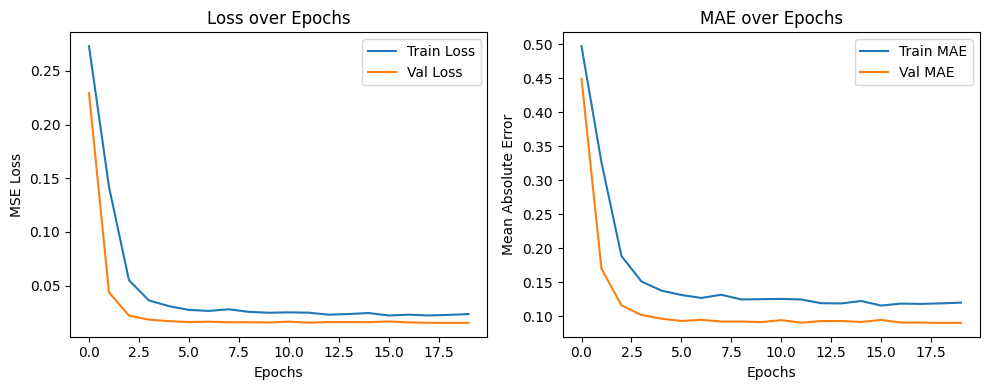

In [ ]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Plot training history for loss and MAE
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("MAE over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

##**2. GNN**
1- As Regression Problem

In [ ]:
file_path = "/content/cleaned_poi_dataset (1).csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

In [ ]:
# Encoding
venue_encoder = LabelEncoder()
df["Venue ID Encoded"] = venue_encoder.fit_transform(df["Venue ID"])

df = df[df["Previous Venue ID"].isin(venue_encoder.classes_)]
df["Previous Venue ID Encoded"] = venue_encoder.transform(df["Previous Venue ID"])

<ipython-input-50-4b3555ac6ed7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Previous Venue ID Encoded"] = venue_encoder.transform(df["Previous Venue ID"])


In [ ]:
# Feature Scaling for Latitude and Longitude
scaler = StandardScaler()
df[["Latitude", "Longitude"]] = scaler.fit_transform(df[["Latitude", "Longitude"]])

# Convert venue IDs to tensor
venue_ids = torch.tensor(df["Venue ID Encoded"].values, dtype=torch.long)

In [ ]:
# Create edges using encoded IDs
edges = list(zip(df["Previous Venue ID Encoded"], df["Venue ID Encoded"]))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Define Graph Structure
num_nodes = venue_ids.shape[0]
mask = (edge_index[0] < num_nodes) & (edge_index[1] < num_nodes)
edge_index = edge_index[:, mask]

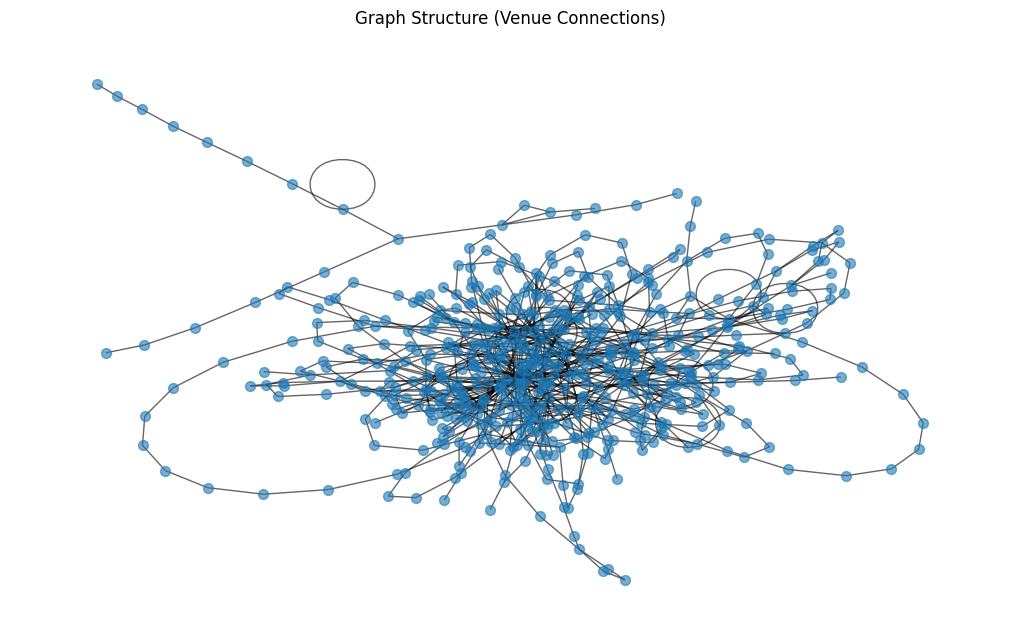

In [ ]:
# Visualize Graph
G = nx.Graph()
G.add_edges_from(edges)
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=50, alpha=0.6)
plt.title("Graph Structure (Venue Connections)")
plt.show()

In [ ]:
# Define Embedding Layer
embedding_dim = 16
embedding_layer = nn.Embedding(num_embeddings=len(venue_encoder.classes_), embedding_dim=embedding_dim)
venue_embeddings = embedding_layer(venue_ids)

# Target Variables: Latitude and Longitude
y = torch.tensor(df[["Latitude", "Longitude"]].values, dtype=torch.float)

# Ensure x and y have the same length
if venue_embeddings.shape[0] > y.shape[0]:
    venue_embeddings = venue_embeddings[: y.shape[0]]
elif y.shape[0] > venue_embeddings.shape[0]:
    y = y[: venue_embeddings.shape[0]]

# Create Graph Data Object
data = Data(x=venue_embeddings, edge_index=edge_index, y=y)

# Define GNN Model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Predict 2 values (Latitude, Longitude)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)  # Output raw values for regression
        return x

In [ ]:
# Initialize Model, Optimizer, and Loss Function
model = GNN(input_dim=embedding_dim, hidden_dim=16, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.HuberLoss()  # Less sensitive to outliers

In [ ]:
# Training Function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward(retain_graph=True)
    optimizer.step()
    return loss.item()

# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.4138
Epoch 10, Loss: 0.4069
Epoch 20, Loss: 0.4021
Epoch 30, Loss: 0.3981
Epoch 40, Loss: 0.3944
Epoch 50, Loss: 0.3907
Epoch 60, Loss: 0.3868
Epoch 70, Loss: 0.3827
Epoch 80, Loss: 0.3785
Epoch 90, Loss: 0.3743
Epoch 100, Loss: 0.3701
Epoch 110, Loss: 0.3660
Epoch 120, Loss: 0.3621
Epoch 130, Loss: 0.3583
Epoch 140, Loss: 0.3546
Epoch 150, Loss: 0.3511
Epoch 160, Loss: 0.3477
Epoch 170, Loss: 0.3442
Epoch 180, Loss: 0.3408
Epoch 190, Loss: 0.3374


In [ ]:
# Evaluate the Model
model.eval()
predictions = model(data.x, data.edge_index).detach()
mse = criterion(predictions, data.y).item()
print(f"Final MSE: {mse:.4f}")

Final MSE: 0.3340


In [ ]:
# Check Predictions vs. Actual Values
def check_predictions():
    model.eval()
    predictions = model(data.x, data.edge_index).detach().numpy()
    actual_values = data.y.numpy()

    # Print sample predictions
    num_samples = min(10, len(predictions))  # Limit to 10 samples
    sample_indices = np.random.choice(len(predictions), num_samples, replace=False)

    print("Sample Predictions vs. Actual Values:")
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]}, Actual: {actual_values[idx]}")

    # Compute error metrics
    errors = np.linalg.norm(predictions - actual_values, axis=1)
    print(f"Mean Error: {np.mean(errors):.4f}, Median Error: {np.median(errors):.4f}")

# Call this function in a separate cell to check results
check_predictions()

Sample Predictions vs. Actual Values:
Predicted: [-0.11479019 -0.28638652], Actual: [-0.38262293 -0.27334926]
Predicted: [-0.25018942 -0.17290016], Actual: [-1.1313735 -1.3159747]
Predicted: [ 0.7984443 -0.6820472], Actual: [ 0.47050318 -1.0924634 ]
Predicted: [-0.6135787  -0.36745796], Actual: [-1.1336609   0.19455333]
Predicted: [ 0.22318383 -0.18979707], Actual: [-0.3028018 -0.6199668]
Predicted: [ 0.20333157 -0.29532632], Actual: [ 0.20447189 -0.08721049]
Predicted: [-0.27106     0.05954333], Actual: [0.13688883 0.25729626]
Predicted: [ 0.11839281 -0.6906716 ], Actual: [ 0.3287684 -1.2005253]
Predicted: [ 0.42288023 -0.39004886], Actual: [ 1.1563627  -0.37394077]
Predicted: [-0.7361706   0.00494495], Actual: [-0.79588246  0.11351726]
Mean Error: 1.0642, Median Error: 0.9436


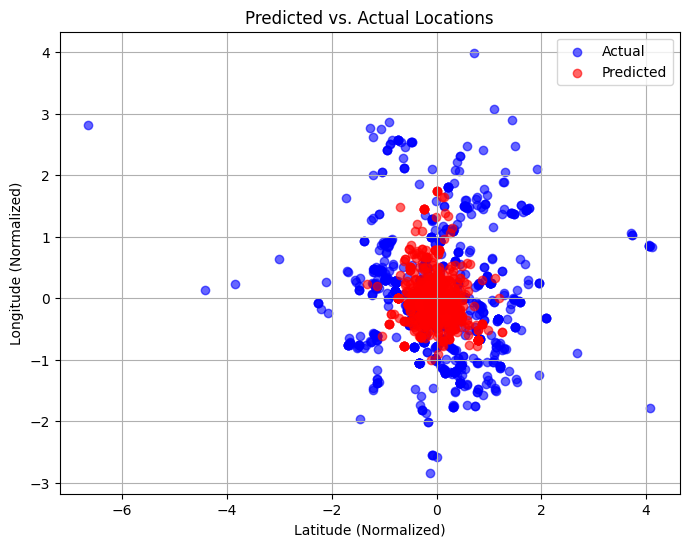

In [ ]:
# Convert tensors to numpy arrays for plotting
predictions_np = predictions.numpy()
actual_np = data.y.numpy()

# Scatter plot for actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_np[:, 0], actual_np[:, 1], color='blue', label='Actual', alpha=0.6)
plt.scatter(predictions_np[:, 0], predictions_np[:, 1], color='red', label='Predicted', alpha=0.6)
plt.xlabel("Latitude (Normalized)")
plt.ylabel("Longitude (Normalized)")
plt.title("Predicted vs. Actual Locations")
plt.legend()
plt.grid(True)
plt.show()

2- As Classification Problem

In [ ]:
df.dropna(subset=["Previous Venue ID", "Venue ID"], inplace=True)
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)

In [ ]:
# Ensure LabelEncoder sees all venue IDs
all_venues = pd.concat([df["Venue ID"], df["Previous Venue ID"]]).unique()
venue_encoder = LabelEncoder()
venue_encoder.fit(all_venues)

# Encode both columns using the same mapping
df["Venue ID"] = venue_encoder.transform(df["Venue ID"])
df["Previous Venue ID"] = venue_encoder.transform(df["Previous Venue ID"])

In [ ]:
# Create Edge Index (Graph Structure)
edges = torch.tensor(df[["Previous Venue ID", "Venue ID"]].values.T, dtype=torch.long)

# Number of venues
num_venues = len(venue_encoder.classes_)

# Node Features (Embedding for Venue IDs)
x = nn.Embedding(num_venues, 16)(torch.arange(num_venues))

# Target (Venue ID to Predict)
y = torch.tensor(df["Venue ID"].values, dtype=torch.long)

data = Data(x=x, edge_index=edges, y=y)

# Define GCN Model
class GCN(nn.Module):
    def __init__(self, num_nodes, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, 32)
        self.conv2 = GCNConv(32, 64)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, edge_index, node_ids):
        x = self.embedding(node_ids)
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        return self.fc(x)

In [ ]:
# Initialize Model, Loss, Optimizer
model = GCN(num_venues, hidden_dim=16, num_classes=num_venues)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(data.edge_index, torch.arange(num_venues))
    loss = criterion(out[df["Previous Venue ID"].values], data.y)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.7760910391807556
Epoch 10: Loss = 0.7813642621040344
Epoch 20: Loss = 0.7758724093437195
Epoch 30: Loss = 0.7779776453971863
Epoch 40: Loss = 0.7759914398193359
Epoch 50: Loss = 0.775242805480957
Epoch 60: Loss = 0.7770540714263916
Epoch 70: Loss = 0.7781211137771606
Epoch 80: Loss = 0.7753145694732666
Epoch 90: Loss = 0.7749788761138916
Epoch 100: Loss = 0.7751032114028931
Epoch 110: Loss = 0.7775375843048096
Epoch 120: Loss = 0.7761542201042175
Epoch 130: Loss = 0.7750643491744995
Epoch 140: Loss = 0.7756001949310303
Epoch 150: Loss = 0.7762898802757263
Epoch 160: Loss = 0.774559736251831
Epoch 170: Loss = 0.7770789265632629
Epoch 180: Loss = 0.7763531804084778
Epoch 190: Loss = 0.7752687931060791


In [ ]:
# Prediction
pred = model(data.edge_index, torch.arange(num_venues)).argmax(dim=1)
y_true = data.y
accuracy = (pred[df["Previous Venue ID"].values] == y_true).sum().item() / len(y_true)
print(f"Prediction Accuracy: {accuracy:.4f}")

Prediction Accuracy: 0.6273


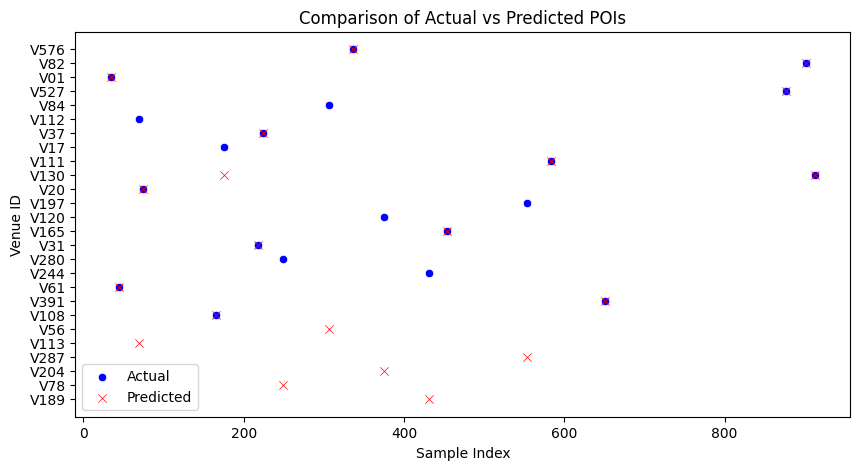

In [ ]:
# Visualizing Prediction Results
df["Predicted Venue ID"] = pred[df["Previous Venue ID"].values].numpy()
df["Predicted Venue ID"] = venue_encoder.inverse_transform(df["Predicted Venue ID"].astype(int))
df["Actual Venue ID"] = venue_encoder.inverse_transform(df["Venue ID"].astype(int))

# Plot a sample of predictions
sample_df = df.sample(n=20, random_state=42)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=sample_df.index, y=sample_df["Actual Venue ID"], label="Actual", marker="o", color="blue")
sns.scatterplot(x=sample_df.index, y=sample_df["Predicted Venue ID"], label="Predicted", marker="x", color="red")
plt.xlabel("Sample Index")
plt.ylabel("Venue ID")
plt.title("Comparison of Actual vs Predicted POIs")
plt.legend()
plt.show()

In [ ]:
# Function to check predictions for a specific user
def check_user_predictions(user_id):
    user_df = df[df["User ID"] == user_id]
    if user_df.empty:
        print(f"No data found for User ID: {user_id}")
        return
    print(user_df[["User ID", "Previous Venue ID", "Actual Venue ID", "Predicted Venue ID"]])

check_user_predictions(1)

    User ID  Previous Venue ID Actual Venue ID Predicted Venue ID
2         1                538            V232                V09
3         1                143            V233               V233
4         1                144            V234               V234
5         1                145            V233               V233
6         1                144            V108               V234
7         1                 14            V235               V145
8         1                146            V214               V214
9         1                126            V215               V215
10        1                127            V216               V216
11        1                128            V217               V217
12        1                129            V204               V204
13        1                115            V218               V187
14        1                130            V219               V219
15        1                131            V220               V220
16        

In [73]:
from sklearn.metrics import f1_score

# Convert tensors to numpy arrays for evaluation
y_true_np = y_true.cpu().numpy()
y_pred_np = pred[df["Previous Venue ID"].values].cpu().numpy()

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np, average="macro")
recall = recall_score(y_true_np, y_pred_np, average="macro")
f1 = f1_score(y_true_np, y_pred_np, average="macro")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6273
Precision: 0.5755
Recall: 0.6200
F1 Score: 0.5688


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#**3. Collaborative Filtering Models**
we will explore
1. User-Based CF
2. Item-Based CF (Using KNN)
3. Matrix Factorization (SVD, NMF, etc.)

##**1- User- Based CF**

In [74]:
# Load the cleaned dataset (adjust the path as necessary)
df = pd.read_csv("/content/cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")

# Remove the 'V' prefix and convert Venue IDs to integers
df["Venue ID"] = df["Venue ID"].astype(str).str.replace("V", "").astype(int)

# Optionally, ensure that User ID is in integer format if not already
df["User ID"] = df["User ID"].astype(int)

# Create a user-venue interaction matrix where cells represent the number of check-ins
user_venue_matrix = df.pivot_table(index="User ID", columns="Venue ID",
                                   values="Check-in Time",
                                   aggfunc="count", fill_value=0)

print("User-Venue Interaction Matrix shape:", user_venue_matrix.shape)
user_venue_matrix.head()

User-Venue Interaction Matrix shape: (23, 576)


Venue ID,1,2,3,4,5,6,7,8,9,11,...,584,585,586,587,588,589,590,591,593,594
User ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,9,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# Initialize NearestNeighbors with cosine similarity (distance = 1 - cosine_similarity)
nn_model = NearestNeighbors(metric="cosine", algorithm="brute")
nn_model.fit(user_venue_matrix)

# For debugging, get the distance and indices for a sample user (e.g., first user in the matrix)
sample_user_idx = 0
distances, indices = nn_model.kneighbors(user_venue_matrix.iloc[[sample_user_idx]], n_neighbors=6)
print("Nearest neighbors (including self) for user", user_venue_matrix.index[sample_user_idx], ":", indices)
print("Distances:", distances)

Nearest neighbors (including self) for user 1 : [[ 0  7  2 12 11 10]]
Distances: [[1.11022302e-16 9.43019712e-01 9.56366810e-01 9.59708852e-01
  9.69542755e-01 9.79093950e-01]]


##**2- Item-Based CF (Using KNN)**

In [76]:
# Load the cleaned dataset (adjust the path if needed)
df = pd.read_csv("/content/cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")

# Remove 'V' prefix and convert Venue IDs to integers (if not done already)
df["Venue ID"] = df["Venue ID"].astype(str).str.replace("V", "").astype(int)
df["User ID"] = df["User ID"].astype(int)

# Create a user-venue interaction matrix where rows = users and columns = venues
user_venue_matrix = df.pivot_table(index="User ID", columns="Venue ID",
                                   values="Check-in Time",
                                   aggfunc="count", fill_value=0)

print("User-Venue Interaction Matrix shape:", user_venue_matrix.shape)
user_venue_matrix.head()

# Transpose to create the item-user interaction matrix:
item_user_matrix = user_venue_matrix.T
print("Item-User Interaction Matrix shape:", item_user_matrix.shape)
item_user_matrix.head()

User-Venue Interaction Matrix shape: (23, 576)
Item-User Interaction Matrix shape: (576, 23)


User ID,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
Venue ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Initialize NearestNeighbors using cosine distance (1 - cosine similarity)
knn_item_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_item_model.fit(item_user_matrix)

# For debugging, get similar venues for a sample venue (e.g., first venue in the matrix)
sample_venue_idx = 0  # Index of the first venue in item_user_matrix
distances, indices = knn_item_model.kneighbors(item_user_matrix.iloc[[sample_venue_idx]], n_neighbors=6)

print("Nearest neighbors (including self) for venue", item_user_matrix.index[sample_venue_idx], ":", indices)
print("Distances:", distances)

Nearest neighbors (including self) for venue 1 : [[216 217   1 212 218 211]]
Distances: [[0. 0. 0. 0. 0. 0.]]


In [78]:
def recommend_item_based(venue_id, item_user_matrix, knn_model, top_n=5):
    """
    Recommend similar venues using item-based collaborative filtering.

    Args:
      venue_id (int): The venue ID for which to find similar items.
      item_user_matrix (pd.DataFrame): The item-user interaction matrix.
      knn_model: Fitted NearestNeighbors model on the item-user matrix.
      top_n (int): Number of similar venues to recommend.

    Returns:
      list: Recommended venue IDs.
    """
    # Ensure the venue exists in the matrix's index
    if venue_id not in item_user_matrix.index:
        print("Venue ID not found in the item-user matrix.")
        return []

    # Get the row corresponding to the venue (convert to 2D array for knn)
    venue_vector = item_user_matrix.loc[[venue_id]]

    # Find nearest neighbors (including itself)
    distances, indices = knn_model.kneighbors(venue_vector, n_neighbors=top_n + 1)

    # Extract the similar venue indices
    similar_indices = indices.flatten().tolist()

    # Remove the venue itself from recommendations
    if similar_indices[0] == item_user_matrix.index.get_loc(venue_id):
        similar_indices = similar_indices[1:]
    else:
        similar_indices = similar_indices[:-1]

    # Map indices back to actual venue IDs using the index of the DataFrame
    recommended_venues = item_user_matrix.index[similar_indices].tolist()
    return recommended_venues

# Example: Test the recommendation function for a sample venue
sample_venue = item_user_matrix.index[0]  # Use the first venue in the matrix
print("Recommendations for venue", sample_venue, ":", recommend_item_based(sample_venue, item_user_matrix, knn_item_model, top_n=5))

Recommendations for venue 1 : [232, 233, 2, 228, 234]


In [79]:
# Evaluate recommendations for the first 5 venues in the item-user matrix
for venue in item_user_matrix.index[:5]:
    recs = recommend_item_based(venue, item_user_matrix, knn_item_model, top_n=5)
    print(f"Recommendations for venue {venue}: {recs}")

Recommendations for venue 1: [232, 233, 2, 228, 234]
Recommendations for venue 2: [232, 233, 2, 228, 234]
Recommendations for venue 3: [232, 233, 2, 228, 234]
Recommendations for venue 4: [232, 233, 2, 228, 234]
Recommendations for venue 5: [232, 233, 2, 228, 234]


#**4. Hybrid Models**



##First Hybrid Model: DAG + LSTM

🔹 Step 1: Build the DAG Model


In [80]:
# Load dataset
df = pd.read_csv("cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")
df.dropna(subset=["User ID", "Previous Venue ID", "Venue ID"], inplace=True)
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)
df["User ID"] = df["User ID"].astype(str)

# Ensure Venue IDs are strings
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)

# Combine both columns before encoding
all_venues = pd.concat([df["Venue ID"], df["Previous Venue ID"]]).unique()
venue_encoder = LabelEncoder()
venue_encoder.fit(all_venues)  # Fit on ALL venue IDs

# Now, encode both columns safely
df["Venue ID"] = venue_encoder.transform(df["Venue ID"])
df["Previous Venue ID"] = venue_encoder.transform(df["Previous Venue ID"])

# Build DAG
def build_dag(df):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        prev_venue = row["Previous Venue ID"]
        next_venue = row["Venue ID"]
        if G.has_edge(prev_venue, next_venue):
            G[prev_venue][next_venue]['weight'] += 1
        else:
            G.add_edge(prev_venue, next_venue, weight=1)
    return G

G_dag = build_dag(df)
print(f"✅ DAG constructed with {G_dag.number_of_nodes()} venues and {G_dag.number_of_edges()} transitions.")

✅ DAG constructed with 583 venues and 911 transitions.


🔹 Step 2: Extract DAG Transition Probabilities

In [81]:
def compute_transition_probs(G):
    transition_probs = {}
    for node in G.nodes():
        total_weight = sum(G[node][neighbor]['weight'] for neighbor in G[node])
        transition_probs[node] = {neighbor: G[node][neighbor]['weight'] / total_weight for neighbor in G[node]}
    return transition_probs

transition_probs = compute_transition_probs(G_dag)

In [82]:
# Normalize latitude and longitude
df["Latitude_norm"] = (df["Latitude"] - df["Latitude"].min()) / (df["Latitude"].max() - df["Latitude"].min())
df["Longitude_norm"] = (df["Longitude"] - df["Longitude"].min()) / (df["Longitude"].max() - df["Longitude"].min())

X_sequences, y_sequences = [], []
user_groups = df.groupby("User ID")

for user, group in user_groups:
    group = group.sort_values("Check-in Time")
    venue_ids = group["Venue ID"].tolist()
    coords = group[["Latitude_norm", "Longitude_norm"]].values

    for i in range(1, len(venue_ids)):
        prev_venue = venue_ids[i-1]
        next_venue = venue_ids[i]

        # Add DAG transition probability as a feature
        transition_prob = transition_probs.get(prev_venue, {}).get(next_venue, 0)

        # Append data
        X_sequences.append([prev_venue, transition_prob])
        y_sequences.append(coords[i])

# Convert sequences to arrays
X = np.array(X_sequences)
y = np.array(y_sequences)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🔹 Step 4: Build the LSTM Model

In [83]:
# Compute correct input dimensions
input_dim = len(venue_encoder.classes_)  # Number of unique venue IDs
embedding_dim = 50  # Embedding vector size
max_seq_len = X_train.shape[1]  # Define sequence length from training data

# Define the model properly
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_seq_len),  # Define input_length
    Masking(mask_value=0),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="linear")  # Predict Latitude, Longitude
])

# Compile the model
model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae"])
model.build(input_shape=(None, max_seq_len))  # Define input shape

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 2, 50)               │          29,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking_1 (Masking)                  │ (None, 2, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2, 128)              │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,496 (681.62 KB)

 Trainable params: 174,496 (681.62 KB)

 Non-trainable params: 0 (0.00 B)

🔹 Step 5: Train the LSTM Model

In [84]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.2835 - mae: 0.5082 - val_loss: 0.2730 - val_mae: 0.5002
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2717 - mae: 0.4964 - val_loss: 0.2490 - val_mae: 0.4772
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2403 - mae: 0.4675 - val_loss: 0.2159 - val_mae: 0.4436
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2063 - mae: 0.4311 - val_loss: 0.1667 - val_mae: 0.3876
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1530 - mae: 0.3663 - val_loss: 0.0978 - val_mae: 0.2895
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0770 - mae: 0.2450 - val_loss: 0.0350 - val_mae: 0.1485
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0330 - mae: 0.1413 - val_loss: 0.0199 - val_mae: 0.1047
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0253 - mae: 0.1242 - val_loss: 0.0183 - val_mae: 0.0996
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.022

🔹 Step 6: Evaluate Model Performance

✅ Test MSE Loss: 0.0165, Test MAE: 0.0943


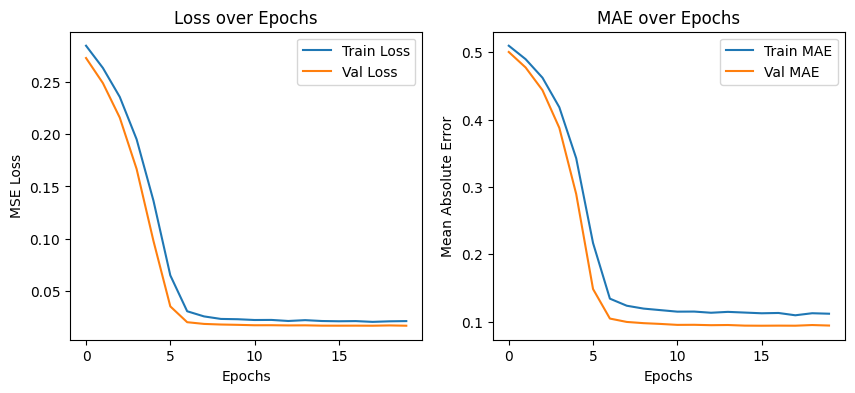

In [85]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("MAE over Epochs")
plt.legend()

plt.show()

##Second Hybrid Model: PPR + LSTM

🔹 Step 1: Build the Personalized PageRank (PPR) Graph

In [86]:
# Load dataset
df = pd.read_csv("cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")
df.dropna(subset=["User ID", "Previous Venue ID", "Venue ID"], inplace=True)
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)
df["User ID"] = df["User ID"].astype(str)

# Ensure Venue IDs are strings
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)

# Combine both columns before encoding
all_venues = pd.concat([df["Venue ID"], df["Previous Venue ID"]]).unique()
venue_encoder = LabelEncoder()
venue_encoder.fit(all_venues)  # Fit on ALL venue IDs

# Now, encode both columns safely
df["Venue ID"] = venue_encoder.transform(df["Venue ID"])
df["Previous Venue ID"] = venue_encoder.transform(df["Previous Venue ID"])

# Build the PPR Graph
G = nx.DiGraph()
for _, row in df.iterrows():
    prev_venue = row["Previous Venue ID"]
    next_venue = row["Venue ID"]
    if G.has_edge(prev_venue, next_venue):
        G[prev_venue][next_venue]['weight'] += 1
    else:
        G.add_edge(prev_venue, next_venue, weight=1)

print(f"✅ Graph Created with {len(G.nodes())} nodes and {len(G.edges())} edges")

✅ Graph Created with 583 nodes and 911 edges


🔹 Step 2: Compute Personalized PageRank (PPR) Scores

In [87]:
def compute_ppr_scores(user_history, alpha=0.3, top_n=5):
    """
    Compute Personalized PageRank (PPR) scores for a user based on their history.

    Args:
        user_history (list): List of previously visited venues.
        alpha (float): PageRank teleportation probability.
        top_n (int): Number of top venues to return.

    Returns:
        dict: Sorted PPR scores for recommended venues.
    """
    if len(user_history) == 0:  # Explicitly check if empty
        return {}

    personalized = {venue: 1.0 for venue in user_history}  # Assign weights to visited venues
    ppr_scores = nx.pagerank(G, alpha=alpha, personalization=personalized)

    # Return top venues based on PageRank score
    return dict(sorted(ppr_scores.items(), key=lambda item: item[1], reverse=True)[:top_n])

# Example Usage
user_history = df[df["User ID"] == "1"]["Previous Venue ID"].dropna().unique()

🔹 Step 3: Prepare Data for LSTM


In [88]:
# Normalize latitude and longitude
df["Latitude_norm"] = (df["Latitude"] - df["Latitude"].min()) / (df["Latitude"].max() - df["Latitude"].min())
df["Longitude_norm"] = (df["Longitude"] - df["Longitude"].min()) / (df["Longitude"].max() - df["Longitude"].min())

X_sequences, y_sequences = [], []
user_groups = df.groupby("User ID")

for user, group in user_groups:
    group = group.sort_values("Check-in Time")
    venue_ids = group["Venue ID"].tolist()
    coords = group[["Latitude_norm", "Longitude_norm"]].values

    for i in range(1, len(venue_ids)):
        prev_venue = venue_ids[i-1]
        next_venue = venue_ids[i]

        # Get PPR score for next venue (default to 0 if not found)
        ppr_scores = compute_ppr_scores(venue_ids[:i])
        ppr_score = ppr_scores.get(next_venue, 0)

        # Append data (Venue ID + PPR Score)
        X_sequences.append([prev_venue, ppr_score])
        y_sequences.append(coords[i])

# Convert sequences to arrays
X = np.array(X_sequences)
y = np.array(y_sequences)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🔹 Step 4: Train the LSTM Model


In [89]:
# Define LSTM model
input_dim = len(venue_encoder.classes_)  # Number of unique venue IDs
embedding_dim = 50  # Embedding vector size
max_seq_len = X_train.shape[1]  # Sequence length

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_seq_len),
    Masking(mask_value=0),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="linear")  # Predict Latitude, Longitude
])

# Compile the model
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mae"])
model.build(input_shape=(None, max_seq_len))  # Define input shape
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 2, 50)               │          29,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking_2 (Masking)                  │ (None, 2, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2, 128)              │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,496 (681.62 KB)

 Trainable params: 174,496 (681.62 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.2186 - mae: 0.4337 - val_loss: 0.0409 - val_mae: 0.1701
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0311 - mae: 0.1414 - val_loss: 0.0153 - val_mae: 0.0931
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0205 - mae: 0.1124 - val_loss: 0.0151 - val_mae: 0.0925
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0196 - mae: 0.1099 - val_loss: 0.0150 - val_mae: 0.0925
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0190 - mae: 0.1058 - val_loss: 0.0154 - val_mae: 0.0940
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194 - mae: 0.1080 - val_loss: 0.0156 - val_mae: 0.0947
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182 - mae: 0.1054 - val_loss: 0.0160 - val_mae: 0.0954
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - mae: 0.1029 - val_loss: 0.0164 - val_mae: 0.0960
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.016

🔹 Step 5: Evaluate Model Performance


✅ Test MSE Loss: 0.0157, Test MAE: 0.0950


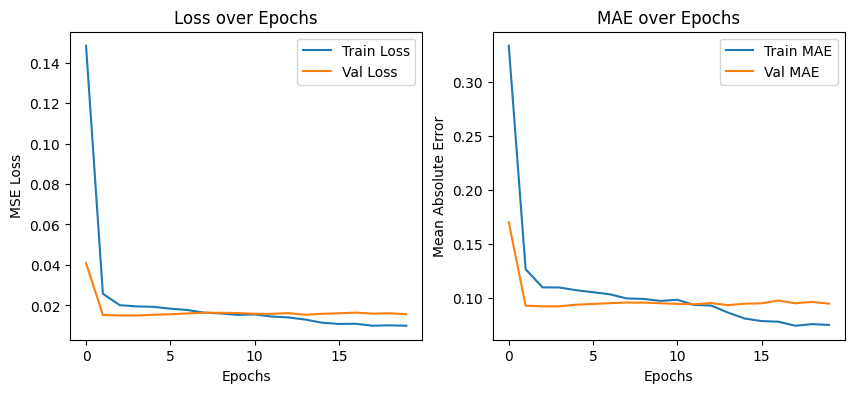

In [91]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("MAE over Epochs")
plt.legend()

plt.show()

##Third Hybrid Model: Node2Vec + LSTM

In [92]:
!pip install node2vec

🔹 Step 1: Build the Graph and Train Node2Vec


In [93]:
# Load dataset
df = pd.read_csv("cleaned_poi_dataset (1).csv", encoding="ISO-8859-1")
df.dropna(subset=["User ID", "Previous Venue ID", "Venue ID"], inplace=True)
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)
df["User ID"] = df["User ID"].astype(str)

# Ensure Venue IDs are strings
df["Venue ID"] = df["Venue ID"].astype(str)
df["Previous Venue ID"] = df["Previous Venue ID"].astype(str)

# Combine both columns before encoding
all_venues = pd.concat([df["Venue ID"], df["Previous Venue ID"]]).unique()
venue_encoder = LabelEncoder()
venue_encoder.fit(all_venues)  # Fit on ALL venue IDs

# Now, encode both columns safely
df["Venue ID"] = venue_encoder.transform(df["Venue ID"])
df["Previous Venue ID"] = venue_encoder.transform(df["Previous Venue ID"])
# Build the transition graph
G = nx.DiGraph()
for _, row in df.iterrows():
    prev_venue = row["Previous Venue ID"]
    next_venue = row["Venue ID"]
    G.add_edge(prev_venue, next_venue, weight=1)

print(f"✅ Graph Created with {len(G.nodes())} nodes and {len(G.edges())} edges")

✅ Graph Created with 583 nodes and 911 edges


📌 Train Node2Vec for Venue Embeddings



In [94]:
# Train Node2Vec model
node2vec = Node2Vec(G, dimensions=50, walk_length=10, num_walks=100, workers=4)
node2vec_model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Save Node2Vec model
node2vec_model.save("node2vec_venue_embeddings.model")
print("✅ Node2Vec model trained and saved.")

Computing transition probabilities:   0%|          | 0/583 [00:00<?, ?it/s]

✅ Node2Vec model trained and saved.


🔹 Step 2: Prepare Data for LSTM


In [95]:
def get_embedding(venue_id):
    """ Fetch Node2Vec embedding for a venue. """
    venue_id = str(venue_id)  # Node2Vec keys are strings
    if venue_id in node2vec_model.wv:
        return node2vec_model.wv[venue_id]
    else:
        return np.zeros(50)  # If venue not found, return zero vector

# Convert all venue IDs to embeddings
df["Venue Embedding"] = df["Venue ID"].apply(get_embedding)

📌 Generate User Check-in Sequences

In [96]:
# Normalize latitude & longitude
df["Latitude_norm"] = (df["Latitude"] - df["Latitude"].min()) / (df["Latitude"].max() - df["Latitude"].min())
df["Longitude_norm"] = (df["Longitude"] - df["Longitude"].min()) / (df["Longitude"].max() - df["Longitude"].min())

X_sequences, y_sequences = [], []
user_groups = df.groupby("User ID")

for user, group in user_groups:
    group = group.sort_values("Check-in Time")
    venue_embeddings = np.stack(group["Venue Embedding"].values)
    coords = group[["Latitude_norm", "Longitude_norm"]].values

    for i in range(1, len(venue_embeddings)):
        X_sequences.append(venue_embeddings[:i])
        y_sequences.append(coords[i])

# Convert sequences to arrays
X = pad_sequences(X_sequences, padding="post", dtype="float32")
y = np.array(y_sequences)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Data prepared: {X_train.shape} training samples, {X_test.shape} test samples.")

✅ Data prepared: (735, 109, 50) training samples, (184, 109, 50) test samples.


🔹 Step 3: Train the LSTM Model


In [97]:
# Define LSTM model
input_shape = X_train.shape[1:]  # (seq_len, embedding_dim)

model = Sequential([
    Masking(mask_value=0, input_shape=input_shape),  # Ignore padded values
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="linear")  # Predict Latitude, Longitude
])

# Compile the model
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mae"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 109, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 109, 128)            │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,346 (567.76 KB)

 Trainable params: 145,346 (567.76 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - loss: 0.1227 - mae: 0.2799 - val_loss: 0.0255 - val_mae: 0.1135
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - loss: 0.0349 - mae: 0.1438 - val_loss: 0.0209 - val_mae: 0.1056
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - loss: 0.0303 - mae: 0.1339 - val_loss: 0.0184 - val_mae: 0.1013
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - loss: 0.0279 - mae: 0.1297 - val_loss: 0.0165 - val_mae: 0.0947
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.0242 - mae: 0.1209 - val_loss: 0.0169 - val_mae: 0.0973
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - loss: 0.0223 - mae: 0.1160 - val_loss: 0.0146 - val_mae: 0.0904
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 0.0226 - mae: 0.1172 - val_loss: 0.0159 - val_mae: 0.0966
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - loss: 0.0213 - mae: 0.1144 - val_loss: 0.0146 - val_mae: 0.0912
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/s

🔹 Step 4: Evaluate Model Performance


✅ Test MSE Loss: 0.0129, Test MAE: 0.0852


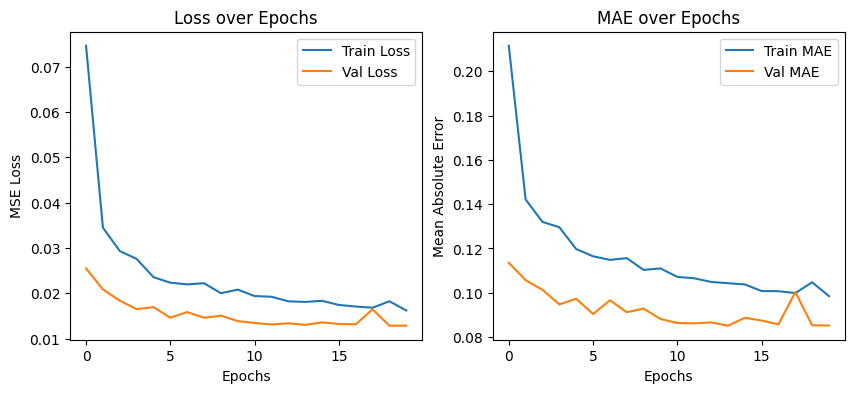

In [99]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("MAE over Epochs")
plt.legend()

plt.show()